In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
import seaborn as sns
import shap
from lime import lime_tabular
import joblib
from glob import glob
from sklearn.inspection import partial_dependence

import sys
sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

from credit_pipeline import training, evaluate
from credit_pipeline.training import EBE # small fix to be able to load models
from credit_pipeline.training import ks_threshold
from credit_pipeline.explainability import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.makedirs("explainability_data", exist_ok = True)

## config

In [3]:
dataset_name = "homecredit"
seed = 0
selected_fold = 0

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
    dataset_name, selected_fold, seed
)

## Global Importances

### pc plots

In [38]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(15,5))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]

    if columns_tick_format is None:
        columns_tick_format = [None for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    x = list(range(len(columns)))
    axx = axes[-1].twinx()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim([-0.05, 1.05])
        # get yticks from ax
        yticks = ax.get_yticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        if format_ is None:
            ax.set_yticklabels([np.round(yi * col_range  + col_min, 1)  for yi in yticks], fontsize = 18)
        else:
            ax.set_yticklabels([format_(yi * col_range  + col_min)  for yi in yticks], fontsize = 18)
        #ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    axes[0].set_ylim([-0.05, 1.05])

    for i, ax in enumerate(axes[:-1]):
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.set_xticklabels([columns_names[i]], fontsize = 18, rotation=45)

    axes[-1].xaxis.set_major_locator(ticker.FixedLocator([i+1, i+2]))
    axes[-1].set_xticklabels([columns_names[i+1], columns_names[i+2]], fontsize = 18, rotation = 45)

    # tick for right side of last axis
    yticks = axes[-1].get_yticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_yticklabels([np.round((yi * col_range +  col_min), 1)  for yi in yticks], fontsize = 18)
    else:
        axx.set_yticklabels([format_(yi * col_range +  col_min)  for yi in yticks], fontsize = 18)
    axx.set_axisbelow(True)
    axx.set_ylim([-0.05, 1.05])
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)

    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [39]:
def parallel_coordinates_vert(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(len(columns)-1, 1, sharex=False, figsize=(5,15))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]
    if columns_tick_format is None:
        columns_tick_format = [lambda x : np.round(x, 1) for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    # Invert to plot first columns at the top
    x = list(range(len(columns)))[::-1]
    axx = axes[0].twiny()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(norm_df.loc[idx, columns], x, c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(norm_df.loc[idx, columns], x, c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_ylim([x[i+1], x[i]])
        ax.set_xlim([-0.05, 1.05])
        xticks = ax.get_xticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        ax.set_xticklabels([format_(yi * col_range  + col_min)  for yi in xticks], fontsize = 18)
    
    axes[0].set_xlim([-0.05, 1.05])

    for i, ax in enumerate(axes):
        #ax.yaxis.set_major_locator(ticker.FixedLocator([i+1]))
        ax.set_yticks([len(axes) - i])
        ax.set_yticklabels([columns_names[i]], fontsize = 18)

    axes[-1].set_yticks([0, 1])
    axes[-1].set_yticklabels([columns_names[-2], columns_names[-1]], fontsize = 18)

    # tick for right side of last axis
    axx.set_facecolor("none")
    xticks = axes[-1].get_xticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_xticklabels([np.round((yi * col_range +  col_min), 1)  for yi in xticks], fontsize = 18)
    else:
        axx.set_xticklabels([format_(yi * col_range +  col_min)  for yi in xticks], fontsize = 18)
    #axx.xaxis.tick_top()
    #axx.set_axisbelow(True)
    #axx.set_xlim([-0.05, 1.05])
    #axx.spines['top'].set_visible(False)
    #axx.spines['bottom'].set_visible(False)

    for ax in list(axes) + [axx]:
        ax.set_facecolor("none")
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)


    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(hspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

### calculate importances

In [91]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []

background_samples = 20
n_samples = 100



for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lr_features_importance.append(model[-1].coef_[0])
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lr_features_importance.append(importances.abs().mean().values)

    features_names = importances.columns.tolist()

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lgbm_features_importance.append(importances.abs().mean().values)


lr_features_importance = pd.DataFrame(
    np.array(lr_features_importance), columns = features_names
) 
lgbm_features_importance = pd.DataFrame(
    np.array(lgbm_features_importance), columns = features_names
)
shap_lr_features_importance = pd.DataFrame(
    np.array(shap_lr_features_importance), columns = features_names
)
shap_lgbm_features_importance = pd.DataFrame(
    np.array(shap_lgbm_features_importance), columns = features_names
)
    

In [81]:
def filter_importance_features(df_importance):
    """Get the median (abs) importance of each feature and select the 10 featuers with highest median importance."""
    importance_values = df_importance.values
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features = df_importance.columns.tolist()
    features_sorted = np.array(features)[sorted_idx]
    return features_sorted

## Global Importances

In [92]:
def plot_pc_importances(df_importance, title = ""):
    features = filter_importance_features(df_importance).tolist()
    n_f = len(features)
    imp_range = [
        df_importance[features].values.min(), df_importance[features].values.max()
    ]
    tick_format = lambda x : f"{x:.2f}"
    parallel_coordinates_vert(
        df_importance,
        features,
        columns_ranges = [imp_range for _ in range(n_f)],
        columns_tick_format = [tick_format for _ in range(n_f)],
        columns_names = features,
        title = title
    )

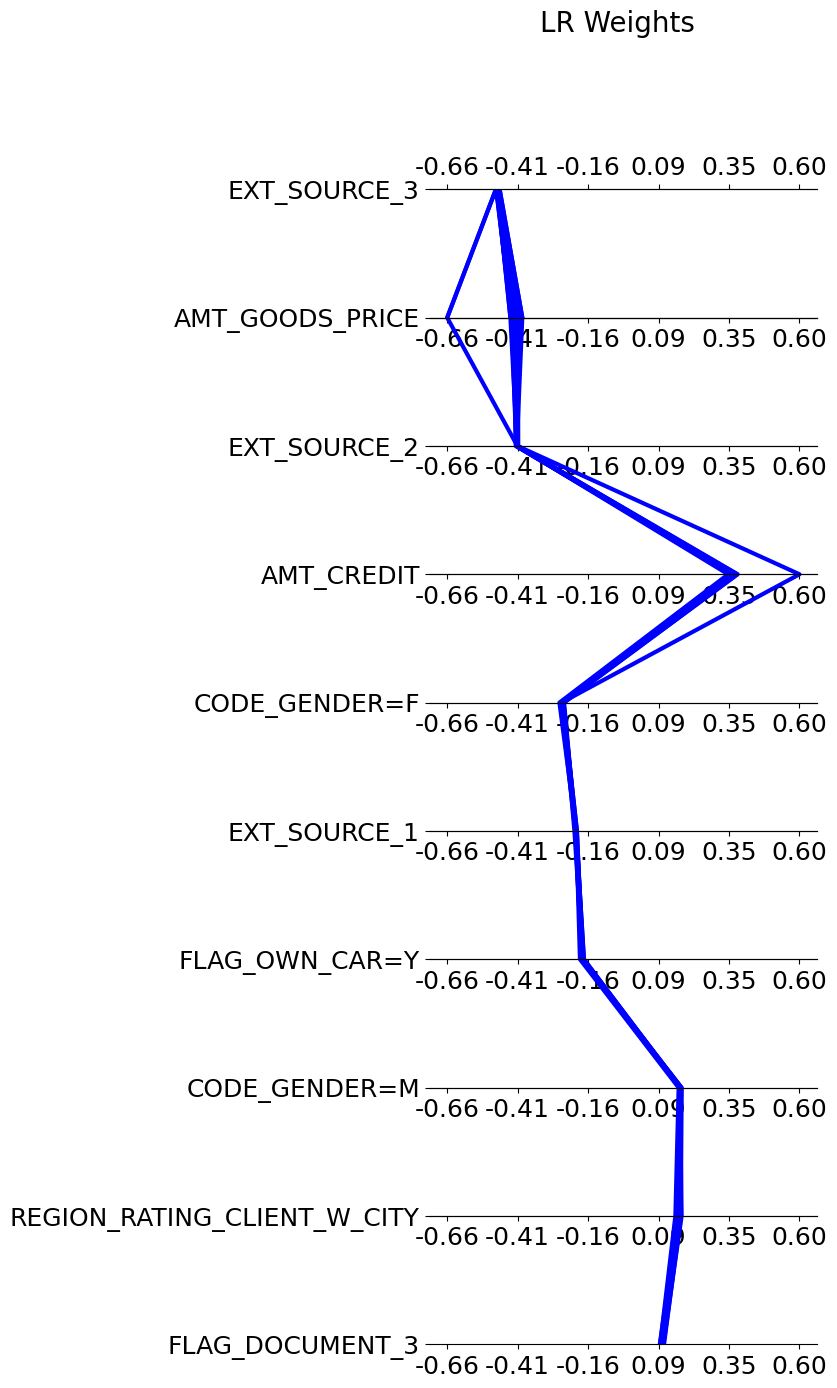

In [97]:
plot_pc_importances(lr_features_importance, "LR Weights")

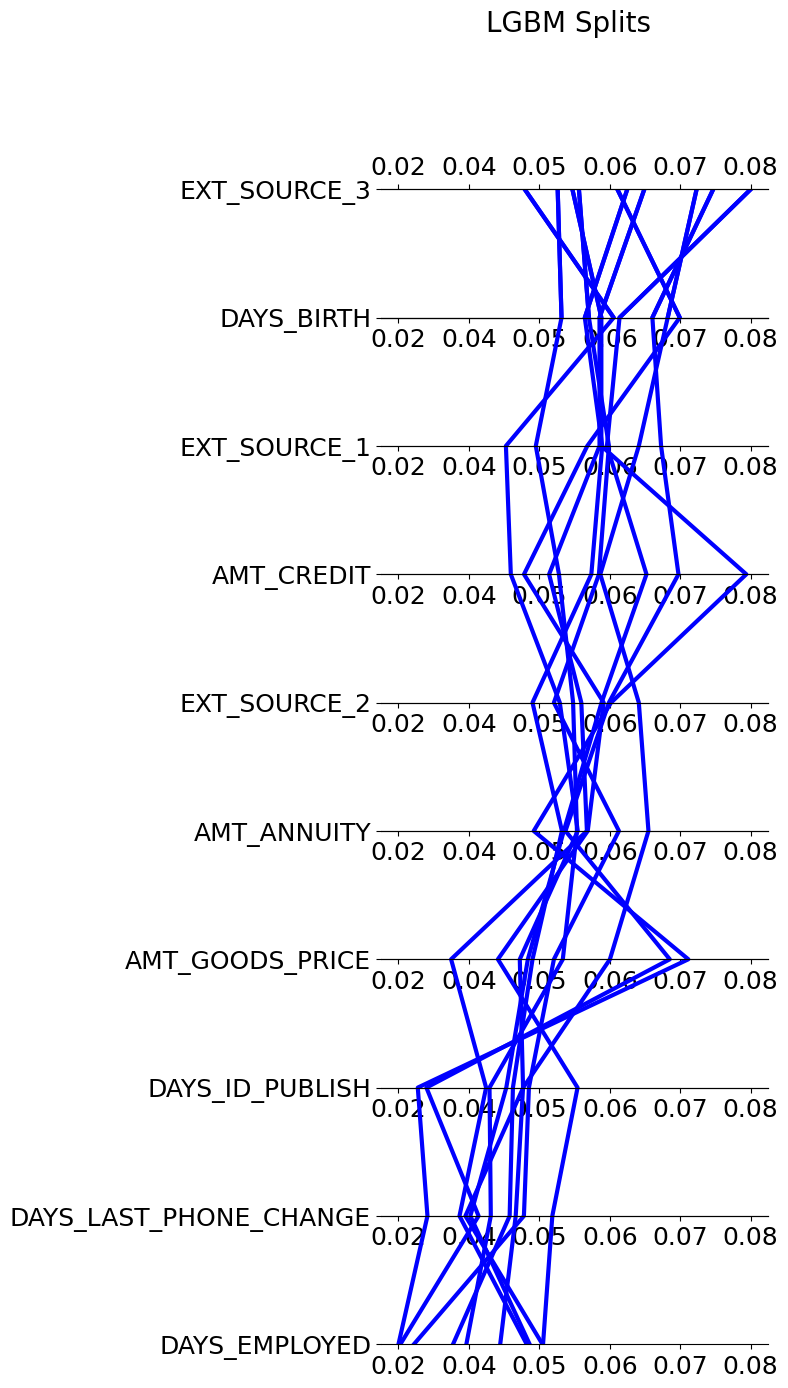

In [98]:
plot_pc_importances(lgbm_features_importance, "LGBM Splits")

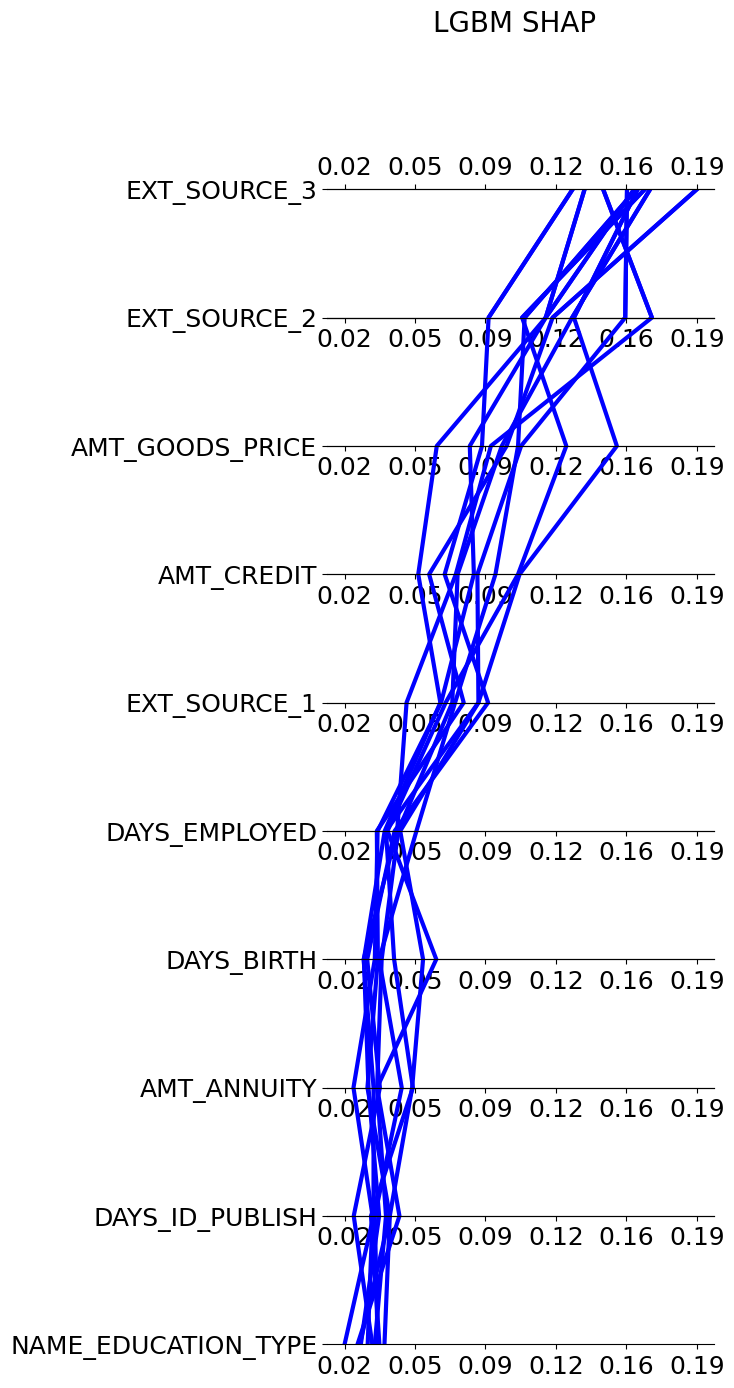

In [99]:
plot_pc_importances(shap_lgbm_features_importance, "LGBM SHAP")

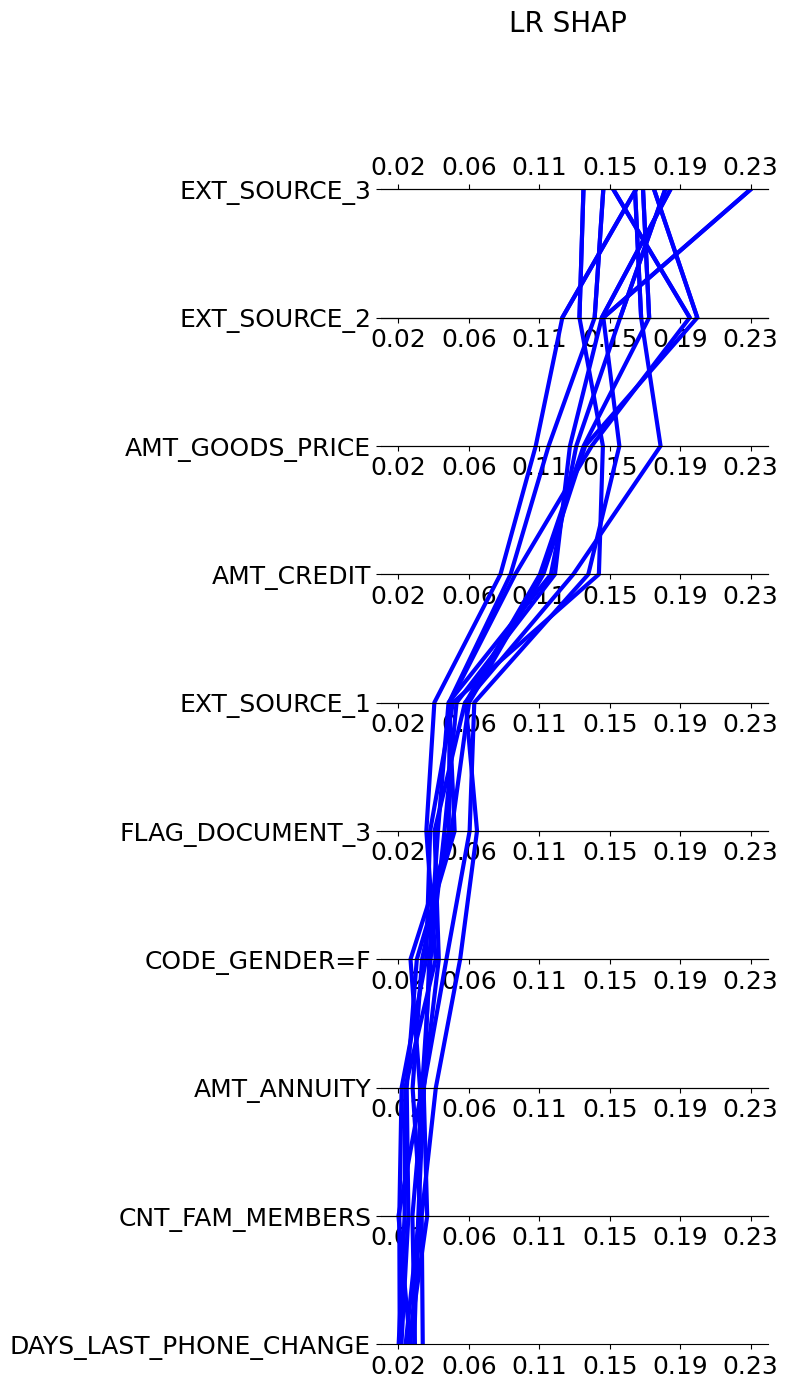

In [100]:
plot_pc_importances(shap_lr_features_importance, "LR SHAP")

## PDP

In [104]:
model_list = [
    joblib.load(f'../results/credit_models/{dataset_name}/{selected_fold}/{model_name}.pkl')
    for model_name in ["LogisticRegression", "LGBMClassifier", "RandomForestClassifier", "MLPClassifier"]
]

In [139]:
def plot_pdp(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model)
        pdp = explainer(X, selected_feature)
        axs[i].plot(pdp["values"], pdp["prediction"])
        axs[i].set_title(model[-1].__class__.__name__)
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Prob")
    plt.tight_layout()
    plt.show()

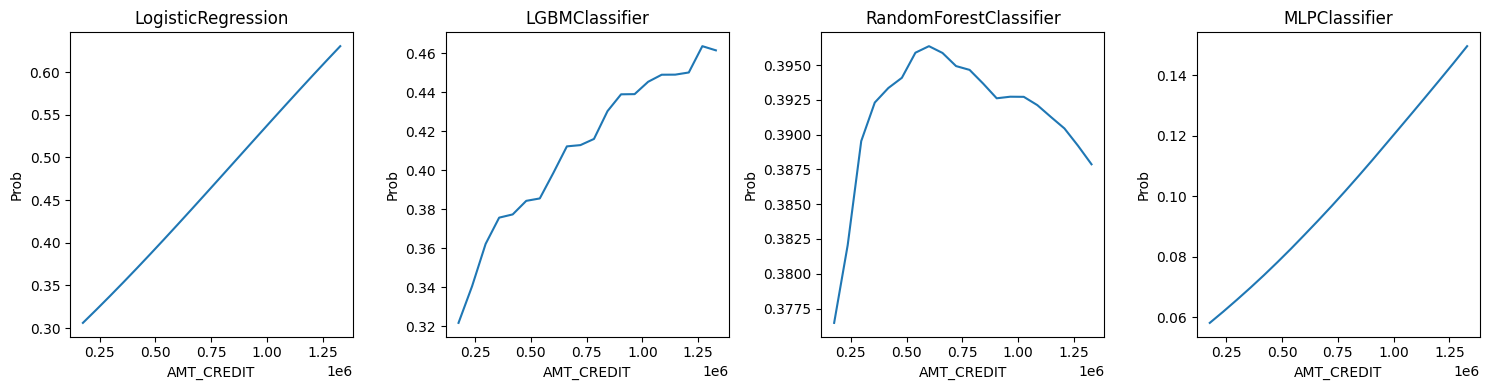

In [140]:
plot_pdp(model_list, X_sample, "AMT_CREDIT")

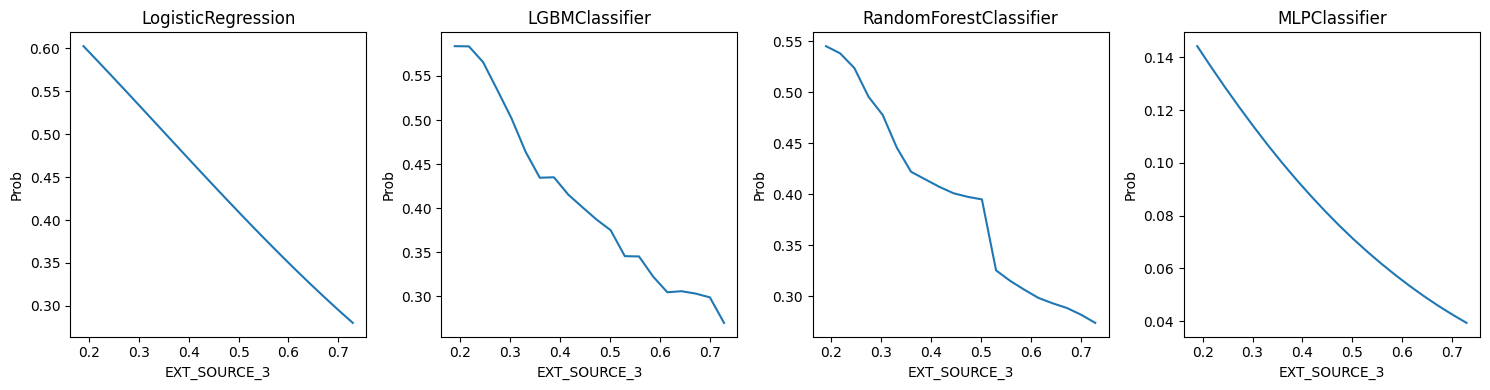

In [143]:
plot_pdp(model_list, X_sample, "EXT_SOURCE_3")

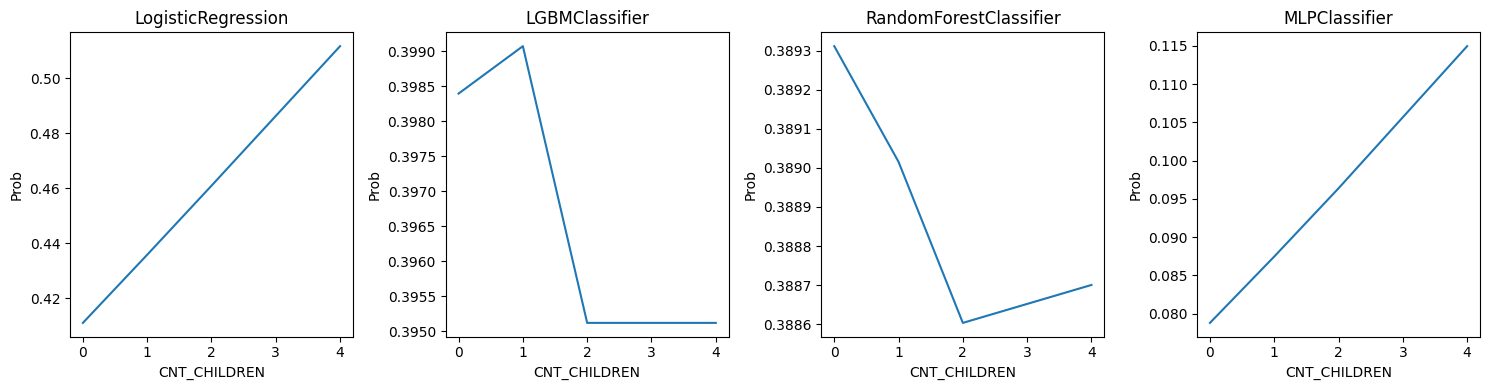

In [144]:
plot_pdp(model_list, X_sample, "CNT_CHILDREN")

## ICE

In [149]:
def plot_ice(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))

    color_code = {
        "M" : "blue",
        "F" : "red",
        "XNA": "yellow"
    }

    
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model, kind = "individual")
        pdp = explainer(X, selected_feature)
        for j in range(X.shape[0]):
            axs[i].plot(pdp["values"], pdp["prediction"][j, :], color_code[X.CODE_GENDER.values[j]], alpha = 0.25)
        axs[i].set_title(model[-1].__class__.__name__)
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Prob")
    plt.tight_layout()
    plt.show()

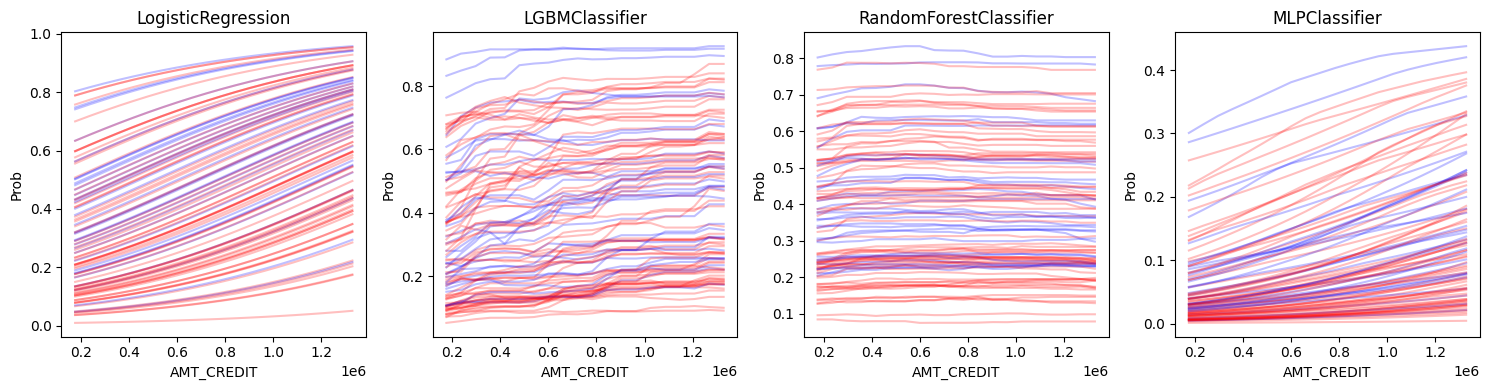

In [150]:
plot_ice(model_list, X_sample, "AMT_CREDIT")

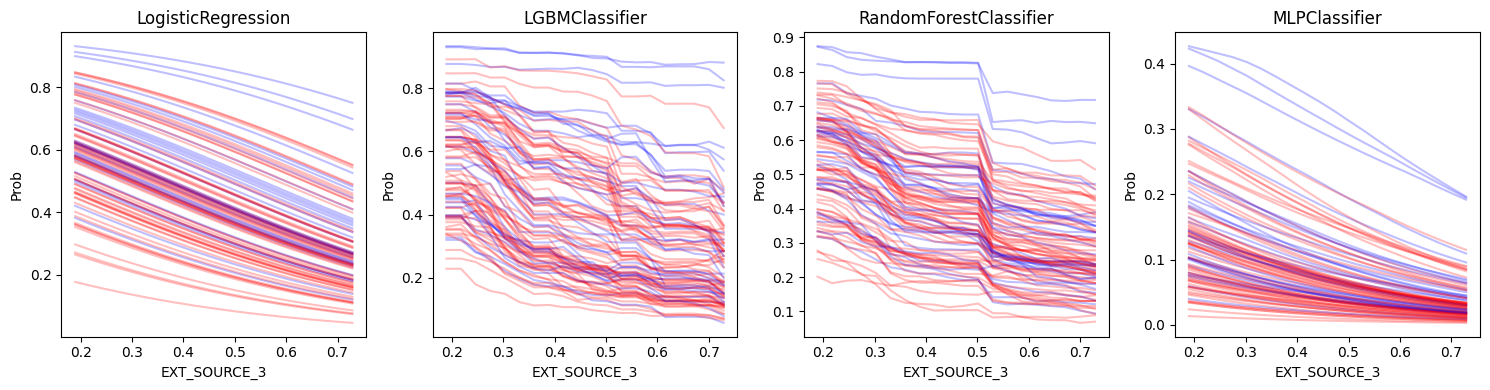

In [151]:
plot_ice(model_list, X_sample, "EXT_SOURCE_3")

## SHAP and LIME

Ref for shap handling of categorical features: https://github.com/shap/shap/issues/397

In [8]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/MLPClassifier.pkl")
X_sample = X_train.sample(100, random_state = seed)

In [19]:
shap_explainer = ShapPipelineExplainer(model, X_sample)
lime_explainer = LimePipelineExplainer(model, X_sample)

In [14]:
from tqdm import tqdm

In [23]:
def filter_columns(importances, top_k = 5):
    if len(importances) == 1:
        v = np.abs(importances.values[0])
        return importances.columns[v.argsort()[::-1]][0:top_k].tolist()
    
for i in tqdm(range(X_train.shape[0])):
    shap_explanation = shap_explainer(X_train.iloc[[i]])
    lime_explanation = lime_explainer(X_train.iloc[[i]])
    
    # check if CODE_GENDER is among the top 5 highest values
    shap_important_features = filter_columns(shap_explanation)
    lime_important_features = filter_columns(lime_explanation)
    if "CODE_GENDER=F" in shap_important_features:
        break
    if "CODE_GENDER=F" in lime_important_features:
        break

  0%|                                                                                                                                                        | 0/221407 [00:00<?, ?it/s]

  0%|                                                                                                                                                        | 0/221407 [00:01<?, ?it/s]


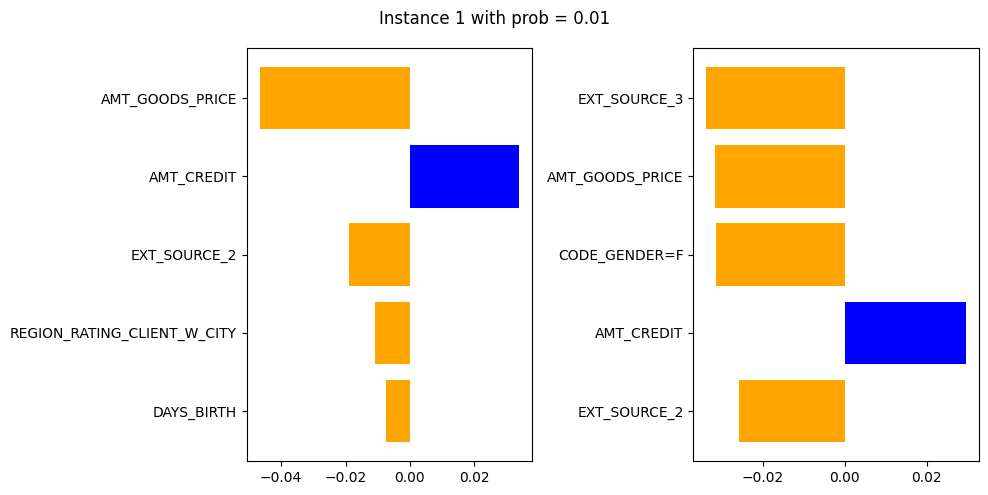

In [36]:
prob = model.predict_proba(X_train.iloc[[i]])[0, 1]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
for i, explanation in enumerate([shap_explanation, lime_explanation]):
    important_features = filter_columns(explanation)
    important_features = important_features[::-1]
    imp = explanation[important_features].values[0]

    
    axs[i].barh(
        important_features,
        imp,
        color = ["orange" if x < 0 else "blue" for x in imp]
    )


plt.suptitle(f"Instance {i} with prob = {prob:.2f}")
plt.tight_layout()
plt.show()

## MAPOCAM and DICE